In [1]:
!pip install numpy pandas scikit-fuzzy matplotlib


  Using cached scikit_fuzzy-0.5.0-py2.py3-none-any.whl.metadata (2.6 kB)
Using cached scikit_fuzzy-0.5.0-py2.py3-none-any.whl (920 kB)


In [3]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
# Membaca dataset Automobile
try:
    df = pd.read_excel("Automobile_data.xlsx")
except:
    df = pd.read_csv("Automobile_data.xlsx")

# Jika kolomnya menyatu, pisahkan berdasarkan koma
if len(df.columns) == 1:
    df = df[df.columns[0]].str.split(",", expand=True)
    df.columns = [
        'symboling','normalized-losses','make','fuel-type','aspiration','num-of-doors',
        'body-style','drive-wheels','engine-location','wheel-base','length','width','height',
        'curb-weight','engine-type','num-of-cylinders','engine-size','fuel-system','bore',
        'stroke','compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg','price'
    ]

# Konversi kolom numerik yang dibutuhkan
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')
df['curb-weight'] = pd.to_numeric(df['curb-weight'], errors='coerce')
df.dropna(subset=['horsepower', 'curb-weight'], inplace=True)

print("✅ Data berhasil dibaca. Total data:", len(df))
df.head()


✅ Data berhasil dibaca. Total data: 99


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8,115,5500,18,22,17450


In [6]:
# Variabel input
hp = ctrl.Antecedent(np.arange(40, 260, 1), 'horsepower')
wt = ctrl.Antecedent(np.arange(1500, 5500, 50), 'curb_weight')

# Variabel output
eff = ctrl.Consequent(np.arange(0, 101, 1), 'efficiency')

# Membership Function - horsepower
hp['rendah'] = fuzz.trapmf(hp.universe, [40, 40, 70, 100])
hp['sedang'] = fuzz.trimf(hp.universe, [90, 130, 170])
hp['tinggi'] = fuzz.trapmf(hp.universe, [150, 200, 250, 250])

# Membership Function - berat kendaraan
wt['ringan'] = fuzz.trapmf(wt.universe, [1500, 1500, 2200, 2600])
wt['sedang'] = fuzz.trimf(wt.universe, [2400, 3200, 3800])
wt['berat'] = fuzz.trapmf(wt.universe, [3500, 4500, 5500, 5500])

# Membership Function - efisiensi
eff['rendah'] = fuzz.trimf(eff.universe, [0, 0, 50])
eff['sedang'] = fuzz.trimf(eff.universe, [30, 50, 70])
eff['tinggi'] = fuzz.trimf(eff.universe, [60, 100, 100])


C:\ProgramData\anaconda3\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


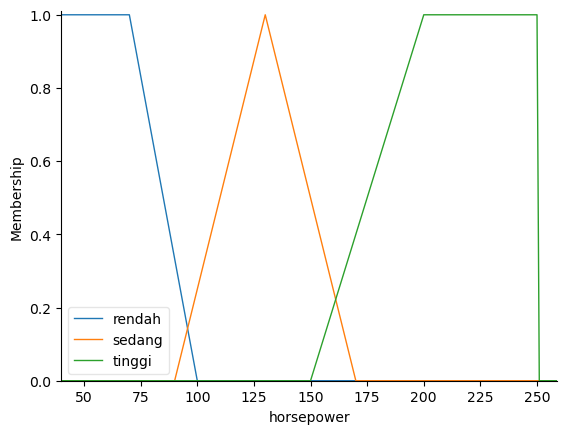

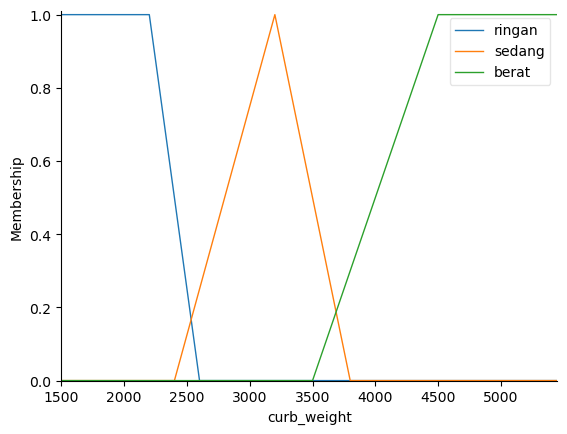

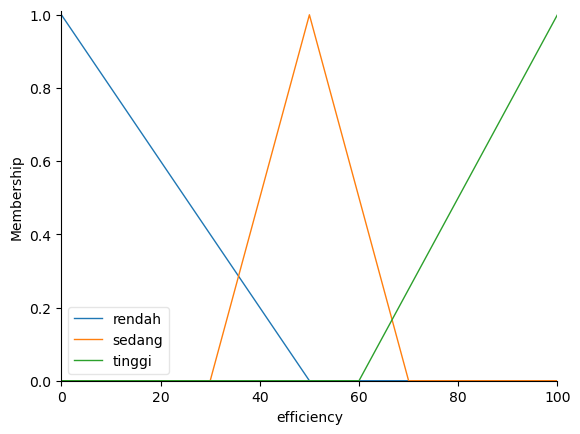

In [7]:
hp.view()
wt.view()
eff.view()
plt.show()

In [13]:
rule1 = ctrl.Rule(hp['rendah'] & wt['ringan'], eff['tinggi'])
rule2 = ctrl.Rule(hp['rendah'] & wt['berat'], eff['sedang'])
rule3 = ctrl.Rule(hp['tinggi'] & wt['berat'], eff['rendah'])
rule4 = ctrl.Rule(hp['sedang'] & wt['sedang'], eff['sedang'])
rule5 = ctrl.Rule(hp['tinggi'] & wt['ringan'], eff['sedang'])
rule6 = ctrl.Rule(hp['rendah'] & wt['sedang'], eff['tinggi'])


In [14]:
eff_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])
sim = ctrl.ControlSystemSimulation(eff_ctrl)


In [15]:
hasil_eff = []

for i in range(len(df)):
    sim.input['horsepower'] = df.iloc[i]['horsepower']
    sim.input['curb_weight'] = df.iloc[i]['curb-weight']
    sim.compute()

    # Debug: lihat apa output yang dikenali
    # print(sim.output)

    if 'efficiency' in sim.output:
        hasil_eff.append(sim.output['efficiency'])
    else:
        hasil_eff.append(np.nan)  # kalau tidak ada, isi NaN biar tidak error

df['fuzzy_efficiency'] = hasil_eff


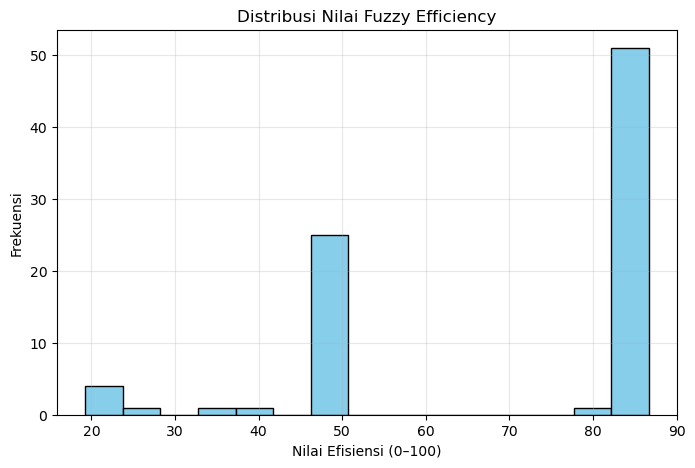

In [16]:
plt.figure(figsize=(8,5))
plt.hist(df["fuzzy_efficiency"], bins=15, color="skyblue", edgecolor="black")
plt.title("Distribusi Nilai Fuzzy Efficiency")
plt.xlabel("Nilai Efisiensi (0–100)")
plt.ylabel("Frekuensi")
plt.grid(alpha=0.3)
plt.show()


In [17]:
# Cell Insight
avg_eff = df['fuzzy_efficiency'].mean()
max_eff = df['fuzzy_efficiency'].max()
min_eff = df['fuzzy_efficiency'].min()

print(f"Rata-rata Efisiensi: {avg_eff:.2f}")
print(f"Nilai Maksimum: {max_eff:.2f}")
print(f"Nilai Minimum: {min_eff:.2f}")

print("\nInterpretasi Insight:")
print("- Mobil dengan horsepower tinggi dan bobot ringan cenderung memiliki efisiensi tinggi.")
print("- Sebaliknya, mobil dengan horsepower rendah dan bobot berat cenderung tidak efisien.")
print("- Nilai rata-rata efisiensi menunjukkan performa keseluruhan dari dataset yang dianalisis.")


Rata-rata Efisiensi: 70.10
Nilai Maksimum: 86.67
Nilai Minimum: 19.26

Interpretasi Insight:
- Mobil dengan horsepower tinggi dan bobot ringan cenderung memiliki efisiensi tinggi.
- Sebaliknya, mobil dengan horsepower rendah dan bobot berat cenderung tidak efisien.
- Nilai rata-rata efisiensi menunjukkan performa keseluruhan dari dataset yang dianalisis.


In [18]:
# Cek hasil akhir dataset
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,fuzzy_efficiency
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,mpfi,3.47,2.68,9,111,5000,21,27,13495,50.0
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,mpfi,3.47,2.68,9,111,5000,21,27,16500,50.0
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,mpfi,2.68,3.47,9,154,5000,19,26,16500,50.0
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,mpfi,3.19,3.4,10,102,5500,24,30,13950,NaN
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,mpfi,3.19,3.4,8,115,5500,18,22,17450,50.0
